# Web Scraping Images
Dataset is created by web scraping the Pexels API to collect the images and store it in the foler respectively.



In [ ]:
import pandas as pd
import requests
import json

Pexels API Documentation is available at : https://www.pexels.com/api/documentation/


In [ ]:
headers = {
    "Authorization" : "FFd111wVuobuWtkaJCkSHqgB9BfMwKFGYIpFtCwohvSiux5wwKPrcafh"
}

In [ ]:
query_words = ["selfie","architecture", "babies", "food", "nature", "people", "pets", "sports", "technology", "wedding"]
page_no = [1, 2, 3, 4, 5]
captions_train = []
captions_valid = []
captions_test = []

In [ ]:
for query in query_words:
  for number in page_no:
    print("Query: {} for the page no: {}".format(query, number))
    get_call = requests.get("https://api.pexels.com/v1/search?query="+query+"&page="+str(number)+"&per_page=80", headers=headers).content
    json_response = json.loads(get_call)
    for i in json_response["photos"]:
      if i["alt"] != "":
        request_url = i["src"]["medium"][:-3] + "800"
        i_data = requests.get(url=request_url, headers=headers).content
        name = query + "-" + request_url.split("?")[0].split('/')[-1].split('-')[-1]
        if number <= 3:
          captions_train.append({"file_name": name, "text": i["alt"]})
          with open("/content/train/" + name, "wb") as handler:
            handler.write(i_data)
        elif number == 4:
          captions_valid.append({"file_name": name, "text": i["alt"]})
          with open("/content/valid/" + name, "wb") as handler:
            handler.write(i_data)
        else:
          captions_test.append({"file_name": name, "text": i["alt"]})
          with open("/content/test/" + name, "wb") as handler:
            handler.write(i_data)

with open("/content/train/metadata.jsonl", 'w') as f:
  for item in captions_train:
    f.write(json.dumps(item) + "\n")
with open("/content/valid/metadata.jsonl", 'w') as f:
  for item in captions_valid:
    f.write(json.dumps(item) + "\n")
with open("/content/test/metadata.jsonl", 'w') as f:
  for item in captions_test:
    f.write(json.dumps(item) + "\n")


Great! We've successfully downloaded images from pexels

# Fine-tune GIT on a custom dataset for image tagging

In this notebook, we'll fine-tune [GIT](https://huggingface.co/docs/transformers/main/en/model_doc/git), short for GenerativeImage2Text.

GIT is, at the moment of writing, a state-of-the-art image/video captioning and question answering (QA) model.

## Set-up environment

First, let's install 🤗 Transformers as well as 🤗 Datasets.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Create image tagging dataset

We'll follow the guide [here](https://huggingface.co/docs/datasets/main/en/image_dataset#image-captioning) to create a 🤗 Dataset, which allows for very fast processing. Basically, we need to add a metadata.jsonl file to our folder containing the images. This metadata file contains the captions, for each of the images.

Load the datasets with the `train` images

In [ ]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="/content/gdrive/MyDrive/CS4444-GiT-data/", split="train")

In [ ]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 2391
})

Let's check whether the dataset is created correctly:

Let's take a look at one example:

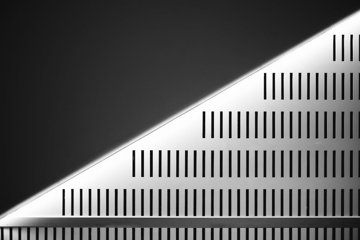

In [ ]:
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

Let's check its corresponding caption:

In [ ]:
example["text"]

'Gray Triangle Illustration'

## Create PyTorch Dataset

Next, we create a standard [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Each item of the dataset returns the expected inputs for the model, in this case input_ids, attention_mask and pixel_values.

We use `GitProcessor` to turn each (image, text) pair into the expected inputs. Basically, the text gets turned into `input_ids` and `attention_mask`, and the image gets turned into `pixel_values`.

In [ ]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [ ]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)

Let's check one example of the dataset:

In [ ]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


## Create PyTorch DataLoader

Next, we create a corresponding [PyTorch DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allows us to get batches of data from the dataset.

We need this as neural networks (like GIT) are trained on batches of data, using stochastic gradient descent (SGD).

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=10)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([10, 512])
attention_mask torch.Size([10, 512])
pixel_values torch.Size([10, 3, 224, 224])


Let's check one batch, and do some sanity checks. We can decode the input_ids back into text for instance:

In [ ]:
processor.decode(batch["input_ids"][0])

'[CLS] man sitting down [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

We can "denormalize" the pixel values to get back an image:

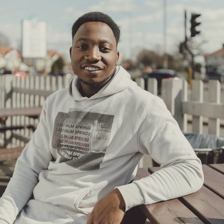

In [ ]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

## Define model

Next, we instantiate a model. We start from the pre-trained GIT-base model (which was already pre-trained on 4 million image-text pairs by Microsoft).

Of course, feel free to start fine-tuning another GIT model from the [hub](https://huggingface.co/models?other=git).

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

## Dummy forward pass

It's always good to check the initial loss on a batch. See also the blog above.

In [ ]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(11.9900, grad_fn=<NllLossBackward0>)

## Train the model

Next, let's train the model! We use native PyTorch here.

In [ ]:
valid_dataset = load_dataset("imagefolder", data_dir="/content/gdrive/MyDrive/CS4444-GiT-data/valid/")
valid_dataset = valid_dataset['train']
valid_dataset

Resolving data files:   0%|          | 0/799 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'text'],
    num_rows: 798
})

In [ ]:
import torch
import numpy as np

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

train_loss = []
num_epochs = 10

for epoch in range(num_epochs):
  batch_loss = []
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)
    attention_mask = batch.pop("attention_mask").to(device)

    outputs = model(input_ids=input_ids,
                    attention_mask=attention_mask,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    batch_loss.append(loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
  train_loss.append(np.mean(batch_loss))
  print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}")


Text(0.5, 0, 'Epochs')

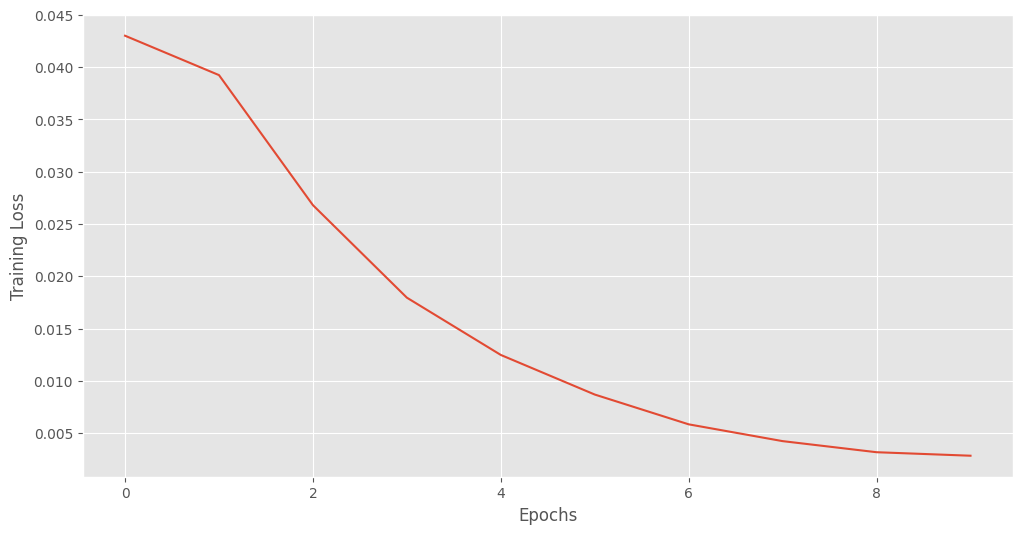

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, (ax2) = plt.subplots(1, figsize=(12, 6), sharex=True)

ax2.plot(train_loss)
ax2.set_ylabel("Training Loss")

ax2.set_xlabel("Epochs")

## **Inference**

In [ ]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoProcessor

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")
processor = AutoProcessor.from_pretrained("microsoft/git-base")

# model has been already trained and the model has been saved.

# torch.save(model.state_dict(), '/content/gdrive/MyDrive/CS4444-GiT-data/git-caption-model.pt')

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.load_state_dict(torch.load('/content/gdrive/MyDrive/CS4444-GiT-data/git-caption-model.pt', map_location=device))
model.to(device)

Importing `nltk` package to remove the stop words

In [ ]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

def remove_stop_punc(sentence):
  stop = set(stopwords.words('english') + list(string.punctuation))
  return " " .join(["#"+i for i in word_tokenize(sentence) if i not in stop])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Testing dataset

In [ ]:
from datasets import load_dataset
test_dataset = load_dataset("imagefolder", data_dir="/content/test/")
test_dataset = test_dataset['train']
test_dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 1
})

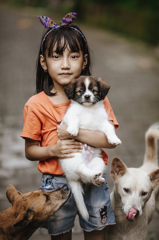

In [ ]:
# load image
example = test_dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_tags = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(remove_stop_punc(generated_tags))

#portrait #smiling #young #woman #dog


In [ ]:
valid_dataset = load_dataset("imagefolder", data_dir="/content/gdrive/MyDrive/CS4444-GiT-data/valid_150/")
valid_dataset = valid_dataset['train']
len(valid_dataset)

In [ ]:
import numpy as np

### Metrics for understanding how well the model performance

In [ ]:
from datasets import list_metrics
list_metrics()

In [ ]:
from datasets import load_metric
bleu_metric = load_metric('bleu')
metor_metric = load_metric('meteor')


bleu_score_list= []
metor_metric_list = []
for i in range(0, len(valid_dataset)):
  example = dataset[i]
  text_original = example["text"]
  valid_image = example["image"]
  inputs = processor(images=valid_image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  bleu_score = bleu_metric.compute(predictions=[generated_caption.split(' ')],references=[[text_original.lower().split(' ')]])
  bleu_score_list.append(bleu_score['bleu'])
  mm = metor_metric.compute(predictions=[generated_caption.split(' ')],references=[[text_original.lower().split(' ')]])
  metor_metric_list.append(mm['meteor'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
print("Average Bleu Score for Validation Images", np.mean(bleu_score_list))
print("Average Meteor Score for Validation Images", np.mean(metor_metric_list))

Average Bleu Score for Validation Images 0.5193302602019403
Average Meteor Score for Validation Images 0.8194831197737185


In [ ]:
for i in test_dataset:
  image = i["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  print(remove_stop_punc(generated_caption))

##FLASK API

### Steps:
- create 'uploads' folder
- upload 'taggit.html' to content
- run the cells below.

In [ ]:
!pip install flask pyngrok flask_ngrok3

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
import os
import sys

from flask import Flask, send_file
from flask_ngrok3 import run_with_ngrok

from pyngrok import ngrok
ngrok.set_auth_token("create_your_own_auth_token")

def init_webhooks(base_url):
    # Update inbound traffic via APIs to use the public-facing ngrok URL
    pass

def create_app():
    app = Flask(__name__)

    run_with_ngrok(app)

    # ... Initialize Blueprints and the rest of our app
    from flask import request
    from PIL import Image

    @app.route('/')
    def index():
        return send_file("taggit.html")

    @app.route('/tag', methods=['GET', 'POST'])
    def upload_file():
        if request.method == 'POST':
            f = request.files['the_file']
            myfile = 'uploads/'+f.filename
            f.save(myfile)
            image = Image.open(myfile)
            width, height = image.size
            display(image.resize((int(0.3*width), int(0.3*height))))
            inputs = processor(images=image, return_tensors="pt").to(device)
            pixel_values = inputs.pixel_values
            generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
            generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
            return(remove_stop_punc(generated_caption))


    return app

In [ ]:
app = create_app()
app.run()

In [ ]:
!ngrok service stop
!pkill ngrok